[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/masadcv/FastGeodis/blob/master/samples/demo3d.ipynb)

In [1]:
! pip install FastGeodis numpy SimpleITK wget -q

In [2]:
import time
from functools import wraps

import torch
import FastGeodis
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import wget
import os

In [3]:
# read images from local path or download from github repo (for colab)
images = [
    "../data/img3d.nii.gz",
]

if not os.path.exists(os.path.dirname(images[0])):
    os.makedirs(os.path.dirname(images[0]), exist_ok=True)

base_url = "https://raw.githubusercontent.com/masadcv/FastGeodis/master/data"
for image in images:
    wget.download(os.path.join(base_url, image), image) if not os.path.exists(image) else None

! ls ../data

brain.png	     image3d_dis1.nii.gz  image3d_sub.nii.gz  ISIC_546.jpg
brain_seg_noisy.png  image3d_dis2.nii.gz  img2d.png
brain_seg.png	     image3d_dis3.nii.gz  img3d.nii.gz


In [4]:
def demo_geodesic_distance3d(image_path, seed_pos):
    SHOW_JOINT_HIST = False
    image_folder = os.path.dirname(image_path)
    image_sitk = sitk.ReadImage(image_path)
    input_image = sitk.GetArrayFromImage(image_sitk)
    spacing_raw = image_sitk.GetSpacing()
    spacing = [spacing_raw[2], spacing_raw[1], spacing_raw[0]]

    input_image = np.asarray(input_image, np.float32)
    input_image = input_image[18:38, 63:183, 93:233]
    seed_image = np.zeros_like(input_image, np.uint8)
    seed_image[seed_pos[0]][seed_pos[1]][seed_pos[2]] = 1

    device = "cpu"
    input_image_pt = torch.from_numpy(input_image).unsqueeze_(0).unsqueeze_(0)
    seed_image_pt = (
        torch.from_numpy(1 - seed_image.astype(np.float32)).unsqueeze_(0).unsqueeze_(0)
    )
    input_image_pt = input_image_pt.to(device)
    seed_image_pt = seed_image_pt.to(device)

    tic = time.time()
    toivanenraster_output = np.squeeze(
        FastGeodis.generalised_geodesic3d_toivanen(
            input_image_pt, seed_image_pt, spacing, 1e10, 1.0, 4
        )
        .detach()
        .cpu()
        .numpy()
    )
    toivanenraster_time = time.time() - tic
    
    tic = time.time()
    fastraster_output_cpu = np.squeeze(
        FastGeodis.generalised_geodesic3d(
            input_image_pt, seed_image_pt, spacing, 1e10, 1.0, 4
        )
        .detach()
        .cpu()
        .numpy()
    )
    fastraster_time_cpu = time.time() - tic

    device = (
        "cuda" if input_image_pt.shape[1] == 1 and torch.cuda.is_available() else None
    )
    if device:
        input_image_pt = input_image_pt.to(device)
        seed_image_pt = seed_image_pt.to(device)
        tic = time.time()
        fastraster_output_gpu = np.squeeze(
            FastGeodis.generalised_geodesic3d(
                input_image_pt, seed_image_pt, spacing, 1e10, 1.0, 4
            )
            .detach()
            .cpu()
            .numpy()
        )
        fastraster_time_gpu = time.time() - tic

    print(
        "Toivanen's CPU raster: {:.6f} s \nFastGeodis CPU raster: {:.6f} s".format(
            toivanenraster_time, fastraster_time_cpu
        )
    )
    if device:
        print("FastGeodis GPU raster: {:.6f} s".format(fastraster_time_gpu))

    img_toivanenraster_output = sitk.GetImageFromArray(toivanenraster_output)
    img_toivanenraster_output.SetSpacing(spacing_raw)
    sitk.WriteImage(
        img_toivanenraster_output, os.path.join(image_folder, "image3d_dis2.nii.gz")
    )

    img_d3 = sitk.GetImageFromArray(fastraster_output_cpu)
    img_d3.SetSpacing(spacing_raw)
    sitk.WriteImage(img_d3, os.path.join(image_folder, "image3d_dis3.nii.gz"))

    input_image_sub = sitk.GetImageFromArray(input_image)
    input_image_sub.SetSpacing(spacing_raw)
    sitk.WriteImage(input_image_sub, os.path.join(image_folder, "image3d_sub.nii.gz"))

    input_image = input_image * 255 / input_image.max()
    input_image = np.asarray(input_image, np.uint8)

    image_slice = input_image[10]
    toivanenraster_output_slice = toivanenraster_output[10]
    fastraster_output_cpu_slice = fastraster_output_cpu[10]
    if device:
        fastraster_output_gpu_slice = fastraster_output_gpu[10]

    plt.figure(figsize=(18, 6))
    plt.subplot(2, 5, 1)
    plt.imshow(image_slice, cmap="gray")
    plt.autoscale(False)
    plt.plot([70], [60], "ro")
    plt.axis("off")
    plt.title("(a) Input image")

    plt.subplot(2, 4, 2)
    plt.imshow(toivanenraster_output_slice)
    plt.axis("off")
    plt.title("(b) Toivanen's Raster (cpu) | ({:.4f} s)".format(toivanenraster_time))
    
    plt.subplot(2, 4, 3)
    plt.imshow(fastraster_output_cpu_slice)
    plt.axis("off")
    plt.title("(c) FastGeodis (cpu) | ({:.4f} s)".format(fastraster_time_cpu))

    plt.subplot(2, 4, 6)
    plt.imshow(toivanenraster_output_slice)
    plt.axis("off")
    plt.title("(d) Toivanen's Raster (cpu) | ({:.4f} s)".format(toivanenraster_time))

    if device:
        plt.subplot(2, 4, 7)
        plt.imshow(fastraster_output_gpu_slice)
        plt.axis("off")
        plt.title("(e) FastGeodis (gpu) | ({:.4f} s)".format(fastraster_time_gpu))

    diff = (
        abs(toivanenraster_output - fastraster_output_cpu) / (toivanenraster_output + 1e-7) * 100
    )
    diff_vol = toivanenraster_output - fastraster_output_cpu
    diff_slice = diff_vol[10]
    plt.subplot(2, 4, 4)
    plt.imshow(diff_slice)
    plt.axis("off")
    plt.title(
        "(f) Fast Marching vs. FastGeodis (cpu)\ndiff: max: {:.4f} | min: {:.4f}".format(
            np.max(diff), np.min(diff)
        )
    )

    if device:
        diff = (
            abs(toivanenraster_output - fastraster_output_gpu)
            / (toivanenraster_output + 1e-7)
            * 100
        )
        diff_vol = toivanenraster_output - fastraster_output_gpu
        diff_slice = diff_vol[10]
        plt.subplot(2, 4, 8)
        plt.imshow(diff_slice)
        plt.axis("off")
        plt.title(
            "(g) Fast Marching vs. FastGeodis (gpu)\ndiff: max: {:.4f} | min: {:.4f}".format(
                np.max(diff), np.min(diff)
            )
        )

    plt.show()

    if SHOW_JOINT_HIST:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist2d(toivanenraster_output.flatten(), fastraster_output_cpu.flatten(), bins=50)
        plt.xlabel("Toivanen's Raster (cpu)")
        plt.ylabel("FastGeodis (cpu)")
        plt.title("Joint histogram\nToivanen's Raster (cpu) vs. FastGeodis (cpu)")

        if device:
            plt.subplot(1, 2, 2)
            plt.hist2d(toivanenraster_output.flatten(), fastraster_output_gpu.flatten(), bins=50)
            plt.xlabel("Toivanen's Raster (cpu)")
            plt.ylabel("FastGeodis (gpu)")
            plt.title("Joint histogram\nToivanen's Raster (cpu) vs. FastGeodis (cpu)")
            # plt.gca().set_aspect("equal", adjustable="box")

        plt.tight_layout()
        plt.show()

Toivanen's CPU raster: 0.318101 s 
FastGeodis CPU raster: 0.228810 s
FastGeodis GPU raster: 0.015081 s


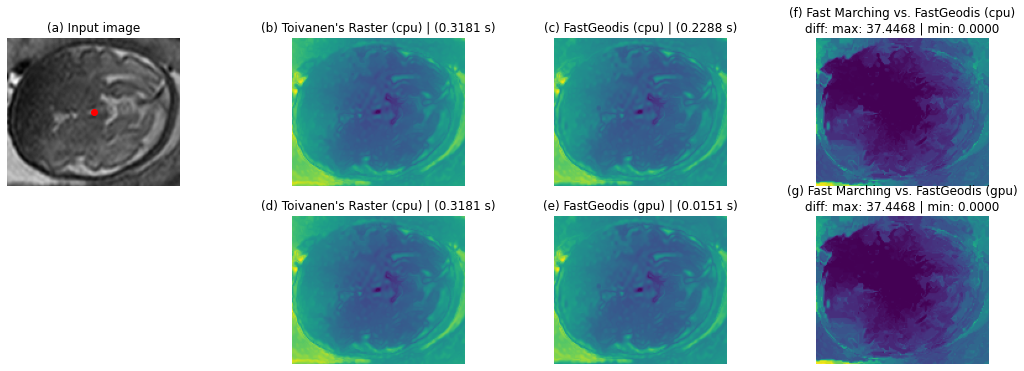

In [5]:
demo_geodesic_distance3d("../data/img3d.nii.gz", [10, 60, 70])